### Homework 4 - Problem 3

For this problem, you will be running a simplified optimal estimation retrieval on real data collected from the CLAMPS1 MWR during BLISSFUL. In this directory, you will find three .py files along with this notebook. One of these is simply this notebook in script form. You will also find `utils.py` and `nonScatMWRadTran.py`. The utilities are functions that I've created to help you on this assignment. I highly encourage you to look them over, especially the ones that directly pertain to running the retrieval (e.g. `do_mwroe_retrieval`, `compute_jacobian_finite_diff`, and `forwardRT`) and make sure you understand how they work. The `nonScatMWRadTran.py` is a pure Python radiative transfer model used in the [Maahn et al. (2020)](https://doi.org/10.1175/BAMS-D-19-0027.1) paper that was mentioned in the online lectures. 

The only non-typical Python libraries you may need to install are `cmocean` and `numba`. These are both simple to install with Conda. 

The data directory contains 4 files:
- clampsmwrC1.a1.20210707.000000.cdf - This is a MWR file collected during BLISSFUL
- KAEFS_20210707_152445.cdf - This is a radiosonde 
- Xa_Sa_datafile.55_levels.month_07.cdf - This is a prior file created for July from the ARM SGP site
- Xa_Sa_datafile.55_levels.month_12.cdf - This is a prior file created for December from the ARM SGP site

As is, this code should produce 2 figures of the prior: one of Xa and one of Sa (converted to a correlation matrix). It will also run an optimal estimation retrieval on the MWR observations from when the included radiosonde was launched. This will be the base retrieval. For this problem, please use this code and any code you develop to do the following:

1. Create a figure that shows the temperature and water vapor profiles from the prior, the base OE retrieval, and the radiosonde. Be sure to include a measure of the uncertainty (e.g. the standard devation) where appropriate.
2. Using the forward model (`utils.forward_RT`), calculate brightness temperatures from the radiosonde observations that can be compared to real observations. Create a figure that shows the difference between the real brightness temperatures and the radiosonde derived brightness temperatures. How do they compare? Why might there be differences? 
3. Rerun the OE retrieval, but double the noise in the MWR measurements. How does this change the resulting profile? How does this change the resulting uncertainty and information content? Provide figures to support your conclusions
4. Rerun the OE retrieval with the original noise estimates, but use the December prior. How does this change the resulting profile? How does this change the resulting uncertainty? Provide figures to support your conclusions


In [205]:
%matplotlib inline

from netCDF4 import Dataset
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from netCDF4 import Dataset

from utils import *

In [206]:
#############
# Read in MWR data from the BLISSFUL campaign
#############

mwr_nc = Dataset('data/clampsmwrC1.a1.20210707.000000.cdf')

# Get the frequencies of the MWR
freqs = mwr_nc['freq'][:].copy()

# Get the times
times = np.array([datetime.utcfromtimestamp(int(d)) for d in mwr_nc['base_time'][0]+mwr_nc['time_offset'][:]])

# Find only the observations at zenith
ind = np.where(mwr_nc['elev'][:] == 90.)[0]
tbsky = mwr_nc['tbsky'][ind, :]
times = times[ind]

mwr_nc.close()

/var/folders/gs/zwmmp28x3fxdv4y3mz__qq280000gn/T/ipykernel_13200/1847175828.py:11: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  times = np.array([datetime.utcfromtimestamp(int(d)) for d in mwr_nc['base_time'][0]+mwr_nc['time_offset'][:]])


In [207]:
#############
# Read in the July prior 
#############
prior_nc = Dataset('data/Xa_Sa_datafile.55_levels.month_07.cdf')  

heights = prior_nc['height'][:].copy() * 1000
prior_t = prior_nc['mean_temperature'][:].copy()
prior_w = prior_nc['mean_mixingratio'][:].copy()
prior_p = prior_nc['mean_pressure'][:].copy()

# Create the prior state vector
Sa = np.asarray(prior_nc['covariance_prior'][:])
Xa = np.append(prior_t, prior_w)

# Get the uncertainties of the profiles
tp_err = np.sqrt(np.diag(Sa)[0:len(heights)])
wp_err = np.sqrt(np.diag(Sa)[len(heights):int(2*len(heights))])

prior_nc.close()

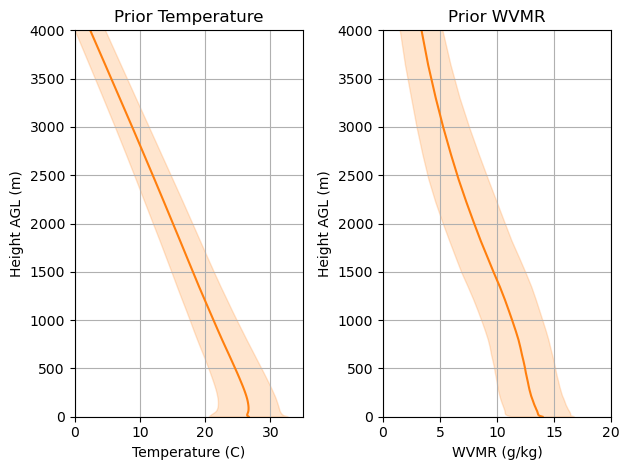

In [208]:
#############
# Plot the prior temperature and uncertainty 
#############
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(prior_t, heights, label='Prior', color='C1')
ax1.fill_betweenx(heights, prior_t+tp_err, prior_t-tp_err, color='C1', alpha=.2)

# Make the figure pretty
ax1.set_xlabel("Temperature (C)")
ax1.set_ylabel("Height AGL (m)")

ax1.set_ylim(0, 4000)
ax1.set_xlim(0, 35)
ax1.grid()
ax1.set_title("Prior Temperature")
          
#############
# Plot the prior temperature and uncertainty 
#############
ax2.plot(prior_w, heights, label='Prior', color='C1')
ax2.fill_betweenx(heights, prior_w+wp_err, prior_w-wp_err, color='C1', alpha=.2)

# Make the figure pretty
ax2.set_xlabel("WVMR (g/kg)")
ax2.set_ylabel("Height AGL (m)")

ax2.set_ylim(0, 4000)
ax2.set_xlim(0, 20)
ax2.grid()
ax2.set_title("Prior WVMR")
plt.tight_layout()
plt.savefig("july_prior.png")
plt.show()

1.0000000000000002


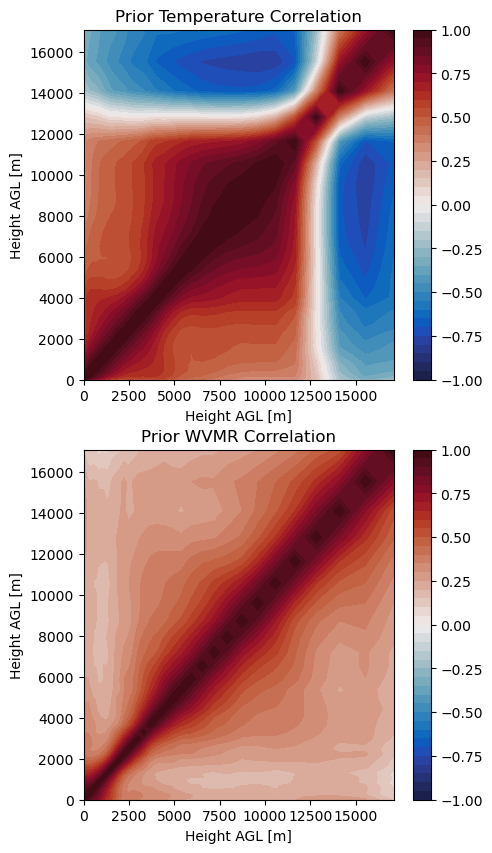

In [209]:
#############
# Plot the prior covariance matrix
#############
fig = corr_plot(cov2corr(Sa), heights)
axes = fig.get_axes()
temp_ax, wv_ax = (axes[0], axes[1])

temp_ax.set_title("Prior Temperature Correlation")
temp_ax.set_xlabel("Height AGL [m]")
temp_ax.set_ylabel("Height AGL [m]")

wv_ax.set_title("Prior WVMR Correlation")
wv_ax.set_xlabel("Height AGL [m]")
wv_ax.set_ylabel("Height AGL [m]")

plt.savefig("july_prior_correlation.png")
plt.show()

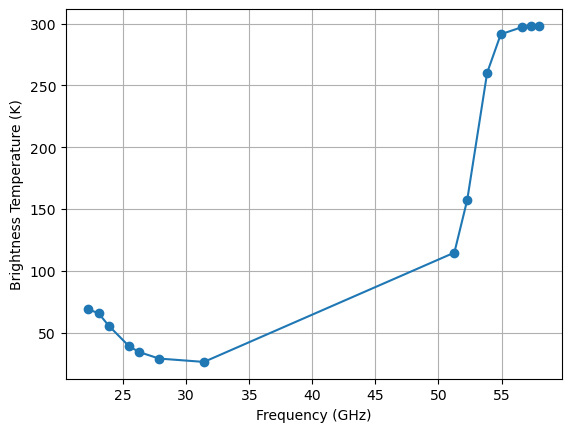

In [210]:
#############
# Run the forward model on the temperature and humidity profile from the prior and plot them
#############
tbs_prior = forwardRT(Xa, heights, prior_p, frequencies=freqs)

plt.figure()
plt.plot(freqs, tbs_prior, '-o')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Brightness Temperature (K)")
plt.grid()
plt.show()


In [211]:
#############
# Read in a radiosonde from BLISSFUL
#############

sonde_nc = Dataset('data/KAEFS_20210707_152445.cdf')

sonde_t = sonde_nc['tdry'][:]
sonde_rh = sonde_nc['relh'][:]
sonde_p = sonde_nc['pres'][:]
sonde_w = rh2w(sonde_t, sonde_rh/100, sonde_p)
sonde_z = sonde_nc['gps_alt_agl'][:]

sonde_nc.close()

In [212]:
# Get the MWR measurements closest to 15:30 UTC (approximately when the sonde was launched)
foo = np.argmin(np.abs(times - datetime(2021, 7, 7, 15, 30)))
time = times[foo]
tbs_mwr = tbsky[foo]

In [213]:
# Build the observation vector. In this case, this is just the MWR Measured brightness temperature
Y = tbs_mwr

# We also need to assign uncertainty to our observations. These are some typical values we use if we haven't measured the system noise recently
# Also note this is a diagonal matrix, so we are not taking into account any channel-to-channel noise correlation
Sy = np.diag([0.3,0.3,0.3,0.3,0.3,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7])

In [214]:
# Now lets do our retrieval! It should converge pretty fast in this case
# This will return the optimal state vector, the posterior covariance matrix, and the forward calculation 

Xop, Sop, Fxn = do_mwroe_retrieval(Xa, Sa, Y, Sy, freqs, prior_p, heights)

####
# Extract out our information into easier to manage arrays
####

t_op = Xop[0:55]  # Optimal temperature profile
w_op = Xop[55:110]  # Optimal WVMR Profile
t_err = np.sqrt(np.diag(Sop)[0:55])  # Post T error (standard deviation)
w_err = np.sqrt(np.diag(Sop)[55:110])  # Post WVMR error (standard deviation)


iter is 0 di2m is 9000000000.0 and RMS is 2.829354170718826
iter is 1 di2m is 19.572000810313227 and RMS is 1.624533492123958
Converged!


In [215]:
np.array(tbs_sonde)-np.array(tbs_op)

array([-1.50614798, -0.92514337,  0.05859538,  0.73100305,  0.78534334,
        0.7981981 ,  0.83013985,  1.71735542,  1.70256348,  0.88404755,
       -0.07738455,  0.27974356,  0.40735534,  0.49756189])

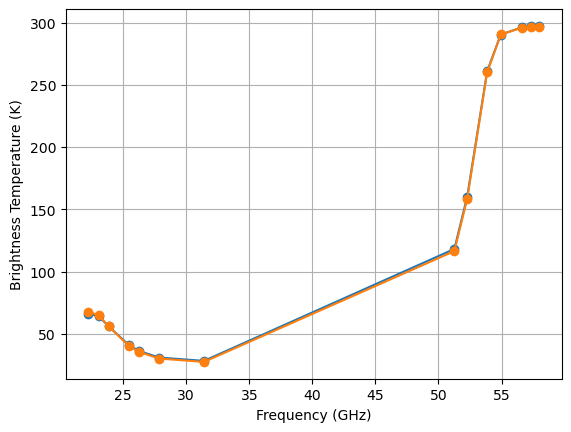

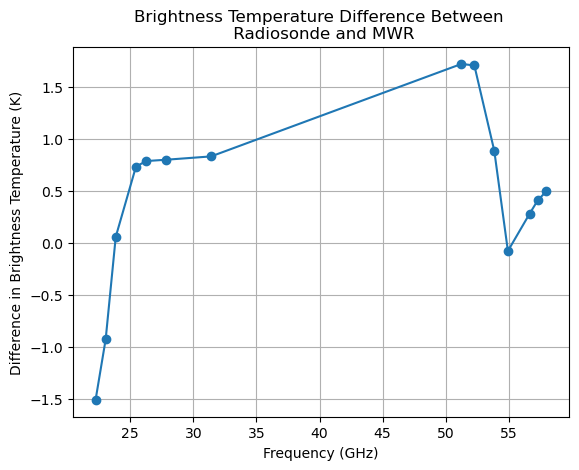

In [216]:
Xs = np.append(sonde_t, sonde_w)

#############
# Run the forward model on the temperature and humidity profile from the prior and plot them
#############
tbs_sonde = forwardRT(Xs, sonde_z, sonde_p, frequencies=freqs)
tbs_op = forwardRT(Xop, heights, prior_p, frequencies=freqs)

plt.figure()
plt.plot(freqs, tbs_sonde, '-o')
plt.plot(freqs, tbs_op, '-o')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Brightness Temperature (K)")
plt.grid()
plt.show()

plt.figure()
plt.title('Brightness Temperature Difference Between \n Radiosonde and MWR')
plt.plot(freqs, np.array(tbs_sonde)-np.array(tbs_op), '-o')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Difference in Brightness Temperature (K)")
plt.grid()
plt.savefig('3b.png')
plt.show()

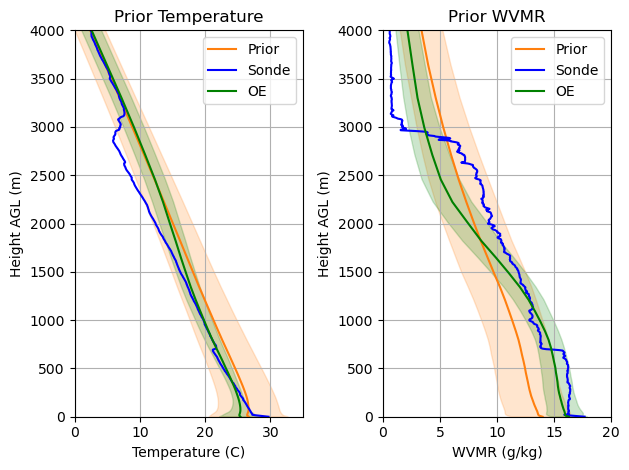

In [217]:
#############
# Plot the prior temperature and uncertainty 
#############
fig, (ax1, ax2) = plt.subplots(1,2)

# plot prior
ax1.plot(prior_t, heights, label='Prior', color='C1')
ax1.fill_betweenx(heights, prior_t+tp_err, prior_t-tp_err, color='C1', alpha=.2)

#plot radiosonde
ax1.plot(sonde_t, sonde_z, label='Sonde', color='b')

ax1.plot(t_op, heights, label='OE', color='g')
ax1.fill_betweenx(heights, t_op+t_err, t_op-t_err, color='g', alpha=.2)

# Make the figure pretty
ax1.set_xlabel("Temperature (C)")
ax1.set_ylabel("Height AGL (m)")

ax1.set_ylim(0, 4000)
ax1.set_xlim(0, 35)
ax1.grid()
ax1.set_title("Prior Temperature")
ax1.legend()
          
#############
# Plot the prior temperature and uncertainty 
#############
ax2.plot(prior_w, heights, label='Prior', color='C1')
ax2.fill_betweenx(heights, prior_w+wp_err, prior_w-wp_err, color='C1', alpha=.2)

ax2.plot(sonde_w, sonde_z, label='Sonde', color='b')

ax2.plot(w_op, heights, label='OE', color='g')
ax2.fill_betweenx(heights, w_op+w_err, w_op-w_err, color='g', alpha=.2)

# Make the figure pretty
ax2.set_xlabel("WVMR (g/kg)")
ax2.set_ylabel("Height AGL (m)")

ax2.set_ylim(0, 4000)
ax2.set_xlim(0, 20)
ax2.grid()
ax2.set_title("Prior WVMR")
ax2.legend()
plt.tight_layout()
plt.savefig("3a.png")
plt.show()

In [218]:
# Build the observation vector. In this case, this is just the MWR Measured brightness temperature
Y = tbs_mwr

# We also need to assign uncertainty to our observations. These are some typical values we use if we haven't measured the system noise recently
# Also note this is a diagonal matrix, so we are not taking into account any channel-to-channel noise correlation
Sy = 2*np.diag([0.3,0.3,0.3,0.3,0.3,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7])

In [219]:
# Now lets do our retrieval! It should converge pretty fast in this case
# This will return the optimal state vector, the posterior covariance matrix, and the forward calculation 

Xop, Sop, Fxn = do_mwroe_retrieval(Xa, Sa, Y, Sy, freqs, prior_p, heights)

####
# Extract out our information into easier to manage arrays
####

t_op_2 = Xop[0:55]  # Optimal temperature profile
w_op_2 = Xop[55:110]  # Optimal WVMR Profile
t_err_2 = np.sqrt(np.diag(Sop)[0:55])  # Post T error (standard deviation)
w_err_2 = np.sqrt(np.diag(Sop)[55:110])  # Post WVMR error (standard deviation)


iter is 0 di2m is 9000000000.0 and RMS is 1.414677085359413
Converged!


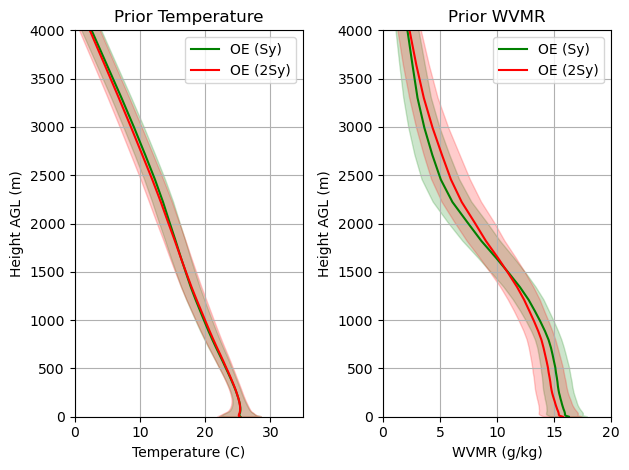

In [220]:
#############
# Plot the prior temperature and uncertainty 
#############
fig, (ax1, ax2) = plt.subplots(1,2)

# plot prior

ax1.plot(t_op, heights, label='OE (Sy)', color='g')
ax1.fill_betweenx(heights, t_op+t_err, t_op-t_err, color='g', alpha=.2)

ax1.plot(t_op_2, heights, label='OE (2Sy)', color='r')
ax1.fill_betweenx(heights, t_op_2+t_err_2, t_op_2-t_err_2, color='r', alpha=.2)

# Make the figure pretty
ax1.set_xlabel("Temperature (C)")
ax1.set_ylabel("Height AGL (m)")

ax1.set_ylim(0, 4000)
ax1.set_xlim(0, 35)
ax1.grid()
ax1.set_title("Prior Temperature")
ax1.legend()
          
#############
# Plot the prior temperature and uncertainty 
#############
ax2.plot(w_op, heights, label='OE (Sy)', color='g')
ax2.fill_betweenx(heights, w_op+w_err, w_op-w_err, color='g', alpha=.2)

ax2.plot(w_op_2, heights, label='OE (2Sy)', color='r')
ax2.fill_betweenx(heights, w_op_2+w_err_2, w_op_2-w_err_2, color='r', alpha=.2)

# Make the figure pretty
ax2.set_xlabel("WVMR (g/kg)")
ax2.set_ylabel("Height AGL (m)")

ax2.set_ylim(0, 4000)
ax2.set_xlim(0, 20)
ax2.grid()
ax2.set_title("Prior WVMR")
ax2.legend()
plt.tight_layout()
plt.savefig("3c.png")
plt.show()

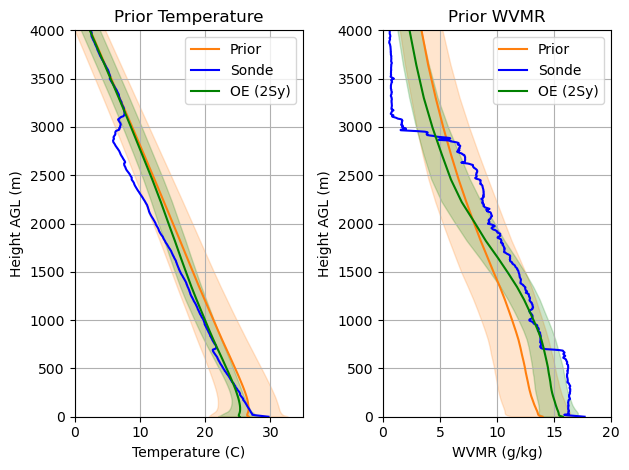

In [222]:
#############
# Plot the prior temperature and uncertainty 
#############
fig, (ax1, ax2) = plt.subplots(1,2)

# plot prior
ax1.plot(prior_t, heights, label='Prior', color='C1')
ax1.fill_betweenx(heights, prior_t+tp_err, prior_t-tp_err, color='C1', alpha=.2)

#plot radiosonde
ax1.plot(sonde_t, sonde_z, label='Sonde', color='b')

ax1.plot(t_op_2, heights, label='OE (2Sy)', color='g')
ax1.fill_betweenx(heights, t_op_2+t_err_2, t_op-t_err_2, color='g', alpha=.2)

# Make the figure pretty
ax1.set_xlabel("Temperature (C)")
ax1.set_ylabel("Height AGL (m)")

ax1.set_ylim(0, 4000)
ax1.set_xlim(0, 35)
ax1.grid()
ax1.set_title("Prior Temperature")
ax1.legend()
          
#############
# Plot the prior temperature and uncertainty 
#############
ax2.plot(prior_w, heights, label='Prior', color='C1')
ax2.fill_betweenx(heights, prior_w+wp_err, prior_w-wp_err, color='C1', alpha=.2)

ax2.plot(sonde_w, sonde_z, label='Sonde', color='b')

ax2.plot(w_op_2, heights, label='OE (2Sy)', color='g')
ax2.fill_betweenx(heights, w_op_2+w_err_2, w_op_2-w_err_2, color='g', alpha=.2)

# Make the figure pretty
ax2.set_xlabel("WVMR (g/kg)")
ax2.set_ylabel("Height AGL (m)")

ax2.set_ylim(0, 4000)
ax2.set_xlim(0, 20)
ax2.grid()
ax2.set_title("Prior WVMR")
ax2.legend()
plt.tight_layout()
plt.savefig("3c.png")
plt.show()

In [223]:
#############
# Read in the July prior 
#############
prior_nc = Dataset('data/Xa_Sa_datafile.55_levels.month_12.cdf')  

heights = prior_nc['height'][:].copy() * 1000
prior_t = prior_nc['mean_temperature'][:].copy()
prior_w = prior_nc['mean_mixingratio'][:].copy()
prior_p = prior_nc['mean_pressure'][:].copy()

# Create the prior state vector
Sa = np.asarray(prior_nc['covariance_prior'][:])
Xa = np.append(prior_t, prior_w)

# Get the uncertainties of the profiles
tp_err_dec = np.sqrt(np.diag(Sa)[0:len(heights)])
wp_err_dec = np.sqrt(np.diag(Sa)[len(heights):int(2*len(heights))])

prior_nc.close()

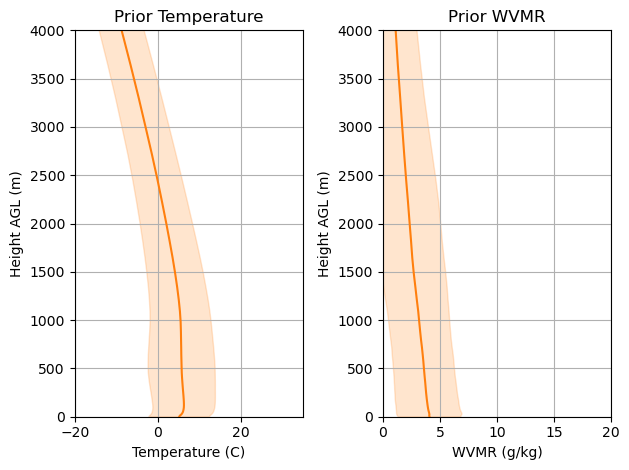

In [224]:
#############
# Plot the prior temperature and uncertainty 
#############
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(prior_t, heights, label='Prior', color='C1')
ax1.fill_betweenx(heights, prior_t+tp_err_dec, prior_t-tp_err_dec, color='C1', alpha=.2)

# Make the figure pretty
ax1.set_xlabel("Temperature (C)")
ax1.set_ylabel("Height AGL (m)")

ax1.set_ylim(0, 4000)
ax1.set_xlim(-20, 35)
ax1.grid()
ax1.set_title("Prior Temperature")
          
#############
# Plot the prior temperature and uncertainty 
#############
ax2.plot(prior_w, heights, label='Prior', color='C1')
ax2.fill_betweenx(heights, prior_w+wp_err, prior_w-wp_err, color='C1', alpha=.2)

# Make the figure pretty
ax2.set_xlabel("WVMR (g/kg)")
ax2.set_ylabel("Height AGL (m)")

ax2.set_ylim(0, 4000)
ax2.set_xlim(0, 20)
ax2.grid()
ax2.set_title("Prior WVMR")
plt.tight_layout()
plt.savefig("dec_prior.png")
plt.show()

In [225]:
# Build the observation vector. In this case, this is just the MWR Measured brightness temperature
Y = tbs_mwr

# We also need to assign uncertainty to our observations. These are some typical values we use if we haven't measured the system noise recently
# Also note this is a diagonal matrix, so we are not taking into account any channel-to-channel noise correlation
Sy = np.diag([0.3,0.3,0.3,0.3,0.3,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7])

In [226]:
# Now lets do our retrieval! It should converge pretty fast in this case
# This will return the optimal state vector, the posterior covariance matrix, and the forward calculation 

Xop, Sop, Fxn = do_mwroe_retrieval(Xa, Sa, Y, Sy, freqs, prior_p, heights)

####
# Extract out our information into easier to manage arrays
####

t_op_dec= Xop[0:55]  # Optimal temperature profile
w_op_dec = Xop[55:110]  # Optimal WVMR Profile
t_err_dec = np.sqrt(np.diag(Sop)[0:55])  # Post T error (standard deviation)
w_err_dec = np.sqrt(np.diag(Sop)[55:110])  # Post WVMR error (standard deviation)


iter is 0 di2m is 9000000000.0 and RMS is 66.80736770938087
iter is 1 di2m is 8933.199758481167 and RMS is 5.629632069614455
iter is 2 di2m is 57.048644409790136 and RMS is 2.6449688089208205
Converged!


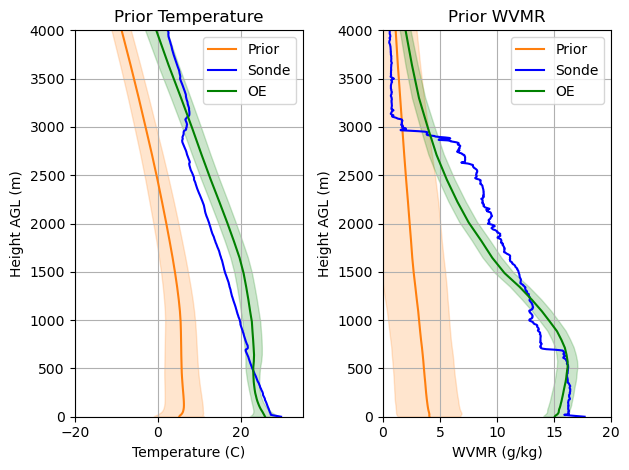

In [227]:
#############
# Plot the prior temperature and uncertainty 
#############
fig, (ax1, ax2) = plt.subplots(1,2)

# plot prior
ax1.plot(prior_t, heights, label='Prior', color='C1')
ax1.fill_betweenx(heights, prior_t+tp_err, prior_t-tp_err, color='C1', alpha=.2)

#plot radiosonde
ax1.plot(sonde_t, sonde_z, label='Sonde', color='b')

ax1.plot(t_op_dec, heights, label='OE', color='g')
ax1.fill_betweenx(heights, t_op_dec+t_err_dec, t_op_dec-t_err_dec, color='g', alpha=.2)

# Make the figure pretty
ax1.set_xlabel("Temperature (C)")
ax1.set_ylabel("Height AGL (m)")

ax1.set_ylim(0, 4000)
ax1.set_xlim(-20, 35)
ax1.grid()
ax1.set_title("Prior Temperature")
ax1.legend()
          
#############
# Plot the prior temperature and uncertainty 
#############
ax2.plot(prior_w, heights, label='Prior', color='C1')
ax2.fill_betweenx(heights, prior_w+wp_err, prior_w-wp_err, color='C1', alpha=.2)

ax2.plot(sonde_w, sonde_z, label='Sonde', color='b')

ax2.plot(w_op_dec, heights, label='OE', color='g')
ax2.fill_betweenx(heights, w_op_dec+w_err_dec, w_op_dec-w_err_dec, color='g', alpha=.2)

# Make the figure pretty
ax2.set_xlabel("WVMR (g/kg)")
ax2.set_ylabel("Height AGL (m)")

ax2.set_ylim(0, 4000)
ax2.set_xlim(0, 20)
ax2.legend()
ax2.grid()
ax2.set_title("Prior WVMR")
plt.tight_layout()
plt.savefig("3D.png")
plt.show()

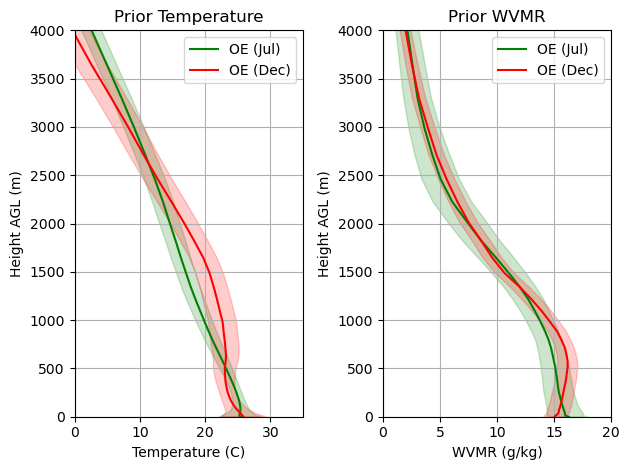

In [230]:
#############
# Plot the prior temperature and uncertainty 
#############
fig, (ax1, ax2) = plt.subplots(1,2)

# plot prior

ax1.plot(t_op, heights, label='OE (Jul)', color='g')
ax1.fill_betweenx(heights, t_op+t_err, t_op-t_err, color='g', alpha=.2)

ax1.plot(t_op_dec, heights, label='OE (Dec)', color='r')
ax1.fill_betweenx(heights, t_op_dec+t_err_dec, t_op_dec-t_err_dec, color='r', alpha=.2)

# Make the figure pretty
ax1.set_xlabel("Temperature (C)")
ax1.set_ylabel("Height AGL (m)")

ax1.set_ylim(0, 4000)
ax1.set_xlim(0, 35)
ax1.grid()
ax1.set_title("Prior Temperature")
ax1.legend()
          
#############
# Plot the prior temperature and uncertainty 
#############
ax2.plot(w_op, heights, label='OE (Jul)', color='g')
ax2.fill_betweenx(heights, w_op+w_err, w_op-w_err, color='g', alpha=.2)

ax2.plot(w_op_dec, heights, label='OE (Dec)', color='r')
ax2.fill_betweenx(heights, w_op_dec+w_err_dec, w_op_dec-w_err_dec, color='r', alpha=.2)

# Make the figure pretty
ax2.set_xlabel("WVMR (g/kg)")
ax2.set_ylabel("Height AGL (m)")

ax2.set_ylim(0, 4000)
ax2.set_xlim(0, 20)
ax2.grid()
ax2.set_title("Prior WVMR")
ax2.legend()
plt.tight_layout()
plt.savefig("3d_b.png")
plt.show()